In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup, AdamW
import torch

import keras
from keras import models,layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer

2023-09-07 21:50:21.131802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
df = pd.read_csv("dataset8.csv")

In [21]:
device = torch.device("cpu")

# Define tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Download model with pretrained weights 
model_bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
model_bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [23]:
# get embeddings for all words in sentences
def embeddings(sentences):
    
    # Add the special tokens with encode plus.
    encoding = tokenizer.encode_plus(sentences, add_special_tokens = True, truncation=True, padding=True,return_attention_mask= True, return_tensors="pt") 

    tokens_tensor = encoding["input_ids"] 
    segments_tensors = encoding["attention_mask"] 
    segments_ids = encoding["token_type_ids"]
    
    with torch.no_grad():

        outputs = model_bert(tokens_tensor.to(device), segments_tensors.to(device)) #fit the vectors into the moedel

    hidden_states = outputs[2] #extraction of hidden states
    
    
    del outputs   #free gpu --- freeing GPU we avoid CUDA out of memory problem on the server.
    

    token_embeddings = torch.stack(hidden_states, dim=0) # torch.Size([13, 1, 73, 768])
    
    token_embeddings = torch.squeeze(token_embeddings, dim=1) #torch.Size([13, 73, 768])
    
    token_embeddings = token_embeddings.permute(1,0,2) #torch.Size([73, 13, 768])
    
    #Extracting CLS embedding
    cls_emb = token_embeddings[0][-4:].mean(dim=0).detach().cpu().numpy() #Extraction of CLS embeddings

    # Alternatively we store the token vectors
    sent_token_vecs_sum = []

    # For each token in the sentence...
    for token in token_embeddings:
        tok = token.to("cpu")   #feed into a cpu
        token.detach() #deletion of the token in GPU 
        del token  

        # Sum last four layers.
        sum_vec = torch.sum(tok[-4:], dim=0)

        sent_token_vecs_sum.append(sum_vec)

    b_emb = torch.stack(sent_token_vecs_sum, dim=0).mean(dim=0).detach().cpu().numpy() #Extraction of the summed embeddings
        
    return b_emb

In [5]:
prompts = df.prompts.to_list()
responses = df.responses.to_list()

summed_embeddings_p = []
summed_embeddings_res = []

for idx in tqdm(range(0, len(prompts)), desc ="Creating prompts embeddings"):
    b_emb_p = embeddings(prompts[idx])
    summed_embeddings_p.append(b_emb_p)
    
for idx in tqdm(range(0, len(responses)), desc ="Creating response embeddings"):
    b_emb_r = embeddings(responses[idx])
    summed_embeddings_res.append(b_emb_r)

Creating response embeddings: 100%|██████████| 32/32 [03:15<00:00,  6.10s/it]


In [24]:
#  Create embeddings for prompts and responses combined
from functools import reduce

both = reduce(lambda i, j: i + [j[0] +" "+ j[1]], zip(prompts, responses),[])
print(both[0])

summed_embeddings_b = []

for idx in tqdm(range(0, len(both)), desc ="Creating combined embeddings"):
    b_emb_b = embeddings(both[idx])
    summed_embeddings_b.append(b_emb_b)

You just heard the surprising news that Adam's date has an artificial leg. You bump into him and ask him how the date went. He replies restlessly: "Great. It was great. She is, uh, she is great, great looking, great personality, she is greatness." "Oh so the date was 'greatness' all around, huh? Sounds like you have truly 'legendary' time!"


Creating combined embeddings: 100%|██████████| 32/32 [03:48<00:00,  7.13s/it]


In [46]:
# The function for training and plotting the validation loss
# We use the mean squared error (MSE) for the loss and mean absolute error (MAE) for the metrics because we are dealing with a regression problem 

def train(model, X_train, y_train):
    model.compile(optimizer='adamax', loss='mse', metrics=['mae'])  
    history = model.fit(X_train, y_train,
                    epochs=12,
                    batch_size=16,
                    validation_split = 0.2,
                    verbose=1)
    
    # Plot the loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return history

In [42]:
labels = df.sarc_chat.to_numpy()

In [66]:
#arrange indices 

indices = np.arange(np.array(summed_embeddings_p).shape[0])
np.random.shuffle(indices)
summed_embeddings = np.array(summed_embeddings_p) #transform into np array

embeddings_p = summed_embeddings[indices]
labels = labels[indices]

p_train, p_test, y_train, y_test = train_test_split(embeddings_p, labels, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

(25,) (7,)


In [69]:
# prompt model

model = Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(768,)))  #model processes batches where each sample has shape(768,).
model.add(layers.Dense(64, activation='relu'))

#model.add(layers.Dropout(0.2)) #weight regularization -- reduce overfitting
#The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant

model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
# The 'None' in the tensor shapes represents the batch size: the model allows batches of any size

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 8)                 6152      
                                                                 
 dense_43 (Dense)            (None, 64)                576       
                                                                 
 dense_44 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,793
Trainable params: 6,793
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
2/2 [==============================] - 1s 177ms/step - loss: 0.7101 - mae: 0.4801 - val_loss: 2.8991 - val_mae: 1.4428
Epoch 2/12
2/2 [==============================] - 0s 59ms/step - loss: 0.6327 - mae: 0.4509 - val_loss: 2.8049 - val_mae: 1.4238
Epoch 3/12
2/2 [==============================] - 0s 67ms/step - loss: 0.6116 - mae: 0.4662 - val_loss: 2.7639 - val_mae: 1.4189
Epoch 4/12
2/2 [==============================] - 0s 71ms/step - loss: 0.6003 - mae: 0.4728 - val_loss: 2.7324 - val_mae: 1.4135
Epoch 5/12
2/2 [==============================] - 0s 66ms/step - loss: 0.5939 - mae: 0.4804 - val_loss: 2.6981 - val_mae: 1.4065
Epoch 6/12
2/2 [==============================] - 0s 56ms/step - loss: 0.5860 - mae: 0.4856 - val_loss: 2.6629 - val_mae: 1.3992
Epoch 7/12
2/2 [==============================] - 0s 54ms/step - loss: 0.5776 - mae: 0.4905 - val_loss: 2.6249 - val_mae: 1.3911
Epoch 8/12
2/2 [==============================] - 0s 37ms/step - loss: 0.5688 - mae: 0.4956 - va

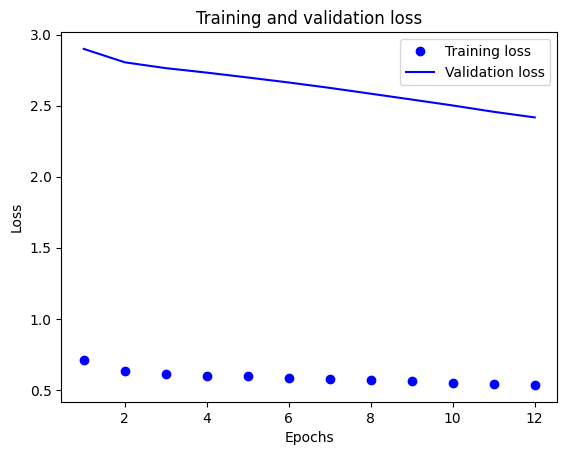

In [70]:
history_prompt = train(model, p_train, y_train)

In [71]:
model.evaluate(p_test, y_test)

1/1 [==============================] - 0s 53ms/step - loss: 1.6576 - mae: 1.1014


[1.6575543880462646, 1.1014047861099243]

### responses

In [49]:
#arrange indices 

indices = np.arange(np.array(summed_embeddings_res).shape[0])
np.random.shuffle(indices)
summed_embeddings_res = np.array(summed_embeddings_res) #transform into np array

embeddings_res = summed_embeddings_res[indices]
labels = labels[indices]

r_train, r_test, y_train, y_test = train_test_split(embeddings_res, labels, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

(25,) (7,)


In [50]:
model_r = Sequential()
model_r.add(layers.Dense(64, activation='relu', input_shape=(768,)))  #model processes batches where each sample has shape(768,).
model_r.add(layers.Dense(64, activation='relu'))

model_r.add(layers.Dense(1, activation='softmax'))
model_r.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                49216     
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 53,441
Trainable params: 53,441
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
2/2 [==============================] - 1s 152ms/step - loss: 2.0885 - mae: 1.1219 - val_loss: 1.2086 - val_mae: 0.9143
Epoch 2/12
2/2 [==============================] - 0s 66ms/step - loss: 2.0885 - mae: 1.1219 - val_loss: 1.2086 - val_mae: 0.9143
Epoch 3/12
2/2 [==============================] - 0s 52ms/step - loss: 2.0885 - mae: 1.1219 - val_loss: 1.2086 - val_mae: 0.9143
Epoch 4/12
2/2 [==============================] - 0s 49ms/step - loss: 2.0885 - mae: 1.1219 - val_loss: 1.2086 - val_mae: 0.9143
Epoch 5/12
2/2 [==============================] - 0s 74ms/step - loss: 2.0885 - mae: 1.1219 - val_loss: 1.2086 - val_mae: 0.9143
Epoch 6/12
2/2 [==============================] - 0s 64ms/step - loss: 2.0885 - mae: 1.1219 - val_loss: 1.2086 - val_mae: 0.9143
Epoch 7/12
2/2 [==============================] - 0s 77ms/step - loss: 2.0885 - mae: 1.1219 - val_loss: 1.2086 - val_mae: 0.9143
Epoch 8/12
2/2 [==============================] - 0s 81ms/step - loss: 2.0885 - mae: 1.1219 - va

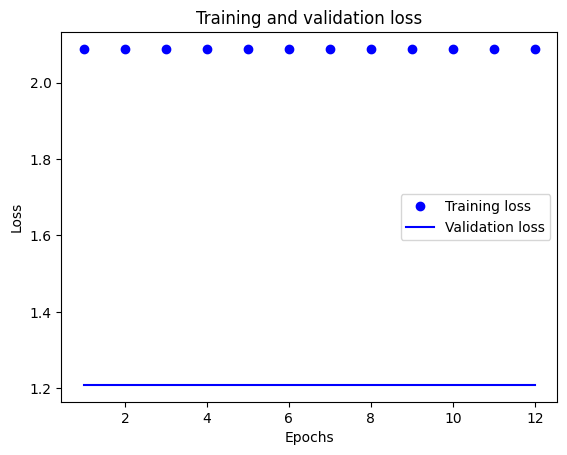

In [51]:
history_res = train(model_r, r_train, y_train)

In [52]:
model_r.evaluate(r_test, y_test)

1/1 [==============================] - 0s 35ms/step - loss: 2.1697 - mae: 1.1871


[2.1696701049804688, 1.187084436416626]

## All texts

In [73]:
#arrange indices 

indices = np.arange(np.array(summed_embeddings_b).shape[0])
np.random.shuffle(indices)
summed_embeddings = np.array(summed_embeddings_b) #transform into np array

embeddings_b = summed_embeddings[indices]
labels = labels[indices]

b_train, b_test, y_train, y_test = train_test_split(embeddings_b, labels, test_size=0.2, random_state=42)

print(y_train.shape, y_test.shape)

(25,) (7,)


In [74]:
# Defining the model for both
model_all = Sequential()


model_all.add(layers.Dense(8, activation='relu', input_shape=(768,)))

model_all.add(layers.Dense(64, activation='relu'))

model_all.add(layers.Dense(1, activation='sigmoid'))

#model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])#tried rmsprop, adagrad but adamax seems better
model_all.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 8)                 6152      
                                                                 
 dense_46 (Dense)            (None, 64)                576       
                                                                 
 dense_47 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,793
Trainable params: 6,793
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
2/2 [==============================] - 1s 175ms/step - loss: 1.2630 - mae: 0.9061 - val_loss: 0.5943 - val_mae: 0.6124
Epoch 2/12
2/2 [==============================] - 0s 58ms/step - loss: 1.1737 - mae: 0.9018 - val_loss: 0.6662 - val_mae: 0.6659
Epoch 3/12
2/2 [==============================] - 0s 64ms/step - loss: 1.1324 - mae: 0.8986 - val_loss: 0.7242 - val_mae: 0.7056
Epoch 4/12
2/2 [==============================] - 0s 72ms/step - loss: 1.1012 - mae: 0.8933 - val_loss: 0.7648 - val_mae: 0.7319
Epoch 5/12
2/2 [==============================] - 0s 69ms/step - loss: 1.0828 - mae: 0.8891 - val_loss: 0.7931 - val_mae: 0.7494
Epoch 6/12
2/2 [==============================] - 0s 58ms/step - loss: 1.0682 - mae: 0.8860 - val_loss: 0.8136 - val_mae: 0.7618
Epoch 7/12
2/2 [==============================] - 0s 72ms/step - loss: 1.0599 - mae: 0.8837 - val_loss: 0.8314 - val_mae: 0.7722
Epoch 8/12
2/2 [==============================] - 0s 64ms/step - loss: 1.0549 - mae: 0.8834 - va

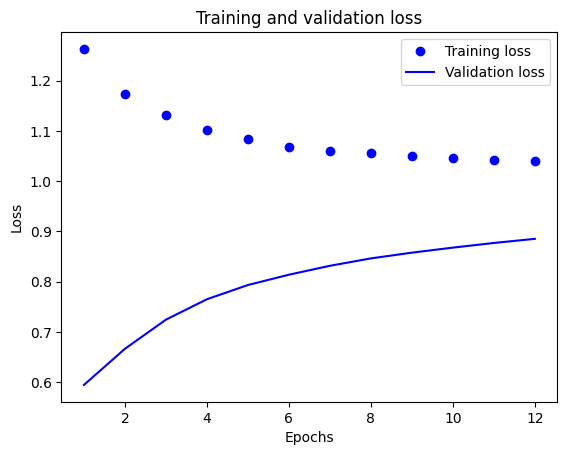

In [75]:
train(model_all, b_train, y_train)

In [65]:
model_all.evaluate(b_test, y_test)

1/1 [==============================] - 0s 46ms/step - loss: 1.3647 - mae: 0.9467


[1.3647441864013672, 0.9467436075210571]